In [234]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az

# A Bayesian analysis method for carbon cycle parameters
This notebook illustrates a proposed fully Bayesian method for incorporating CMIP model estimates and emergent constraints. As an example, we constrain the land carbon response to increasing temperatures ($\gamma_L$) using CMIP model simulations and the constraint on tropical $\gamma_L$ from internal variability proposed by Cox et al 2013.

## Reading in the data
Data from three generations of CMIP models is provided by Jones and Friedlingstein https://iopscience.iop.org/article/10.1088/1748-9326/ab858a

In [514]:

url = "https://docs.google.com/spreadsheets/d/14n6npj77hl-bGkNhE3wHSWS4Xt-Zd9Ww/export?format=csv&gid=99467917"
df = pd.read_csv(url,header=9)
#Optional: display the dataframe to make sure it loaded properly
display=False
if display:
    df

Split the data up by generation and read in $\gamma$ (specify whether we want land, ocean, or total)

In [515]:
variable_to_estimate = 'γL (PgC K-1)'
#variable_to_estimate = 'γtot (PgC K-1)'

split5,split6=np.where(df["model"]=="model")[0]

c4mip=df[:split5-2]
cmip5=df[split5+1:split6-2]
cmip6=df[split6+1:]

# Dictionary of γ
gammas={}
gammas["C4MIP"]=c4mip[variable_to_estimate].values.astype(np.float32)
gammas["CMIP5"]=cmip5[variable_to_estimate].values.astype(np.float32)
gammas["CMIP6"]=cmip6[variable_to_estimate].values.astype(np.float32)

### $\gamma$ over generations
Visualizing $\gamma_L$ in three model generations.  Note CMIP5 and CMIP6 estimates are less uncertain and less negative than C4MIP.

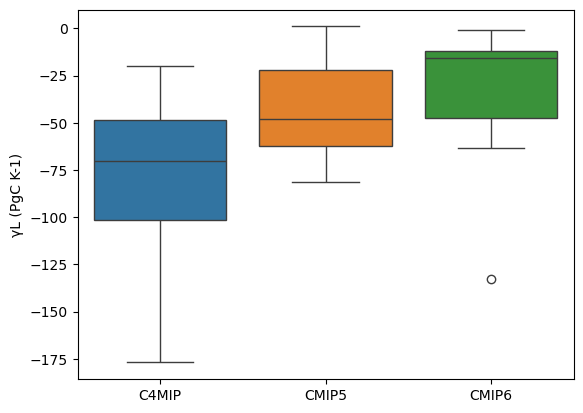

In [516]:
sns.boxplot(gammas)
tmp=plt.ylabel(variable_to_estimate)

## Unavoidable choices
An analyst needs to make subjective decisions about how to combine estimates from the three generations of climate models. Do we assume all of them are equally likely to capture the ``true" value of $\gamma_L$?  Do we assume there will be a nonzero spread between different model generations?  Do we assume the CMIP models get better with time, and truest the latest generation more?  We have to make choices:
- Choosing the model: We need to select a (analytical) model to combine the results.  Here, I've chosen a simple random effects model with parameters $mu_i$ (the latent true mean $\gamma_L$ of generation $i$), $\sigma_i$ (true standard deviation of generation $i$), $\tau$ (heterogeneity parameter representing the spread between different model generations), and the true value of $\gamma_L$.  Other models are of course possible- we might simply pool all three generations or assume earlier generations are biased.  
  
- Putting priors on the parameters: The model I've chosen requires two main prior choices: our previous knowledge about $\gamma_L$ and our knowledge about the spreac (between generations) $\tau$.

In [570]:
def build_model(prior_dict):
    with pm.Model() as model:
        ## Specify your prior on -γ
        neg_gamma_prior=prior_dict["neg_gamma"]
        #true_gamma=pm.Deterministic("true_gamma",-1*neg_gamma)
        tau_prior = prior_dict["tau"]     # Prior on heterogeneity between CMIP generations

        #use them in the model
        true_gamma = pm.Deterministic("true_gamma",neg_gamma_prior(name='neg_gamma')*-1)
        tau = tau_prior(name="tau")
        
        #containers for generation means and sigmas
        sigmas={}
        mus={}
        obs={}
        for generation in gammas.keys():
            # prior on generation spread
            sigmas[generation]=np.std(gammas[generation])#pm.HalfNormal("sigma_"+generation, 100)
            #mus[generation]=pm.Normal("mu_"+generation,true_gamma,tau)
            mus[generation]=pm.Normal("mu_"+generation,true_gamma,tau)
            obs[generation]=pm.Normal("obs_"+generation,mus[generation],sigmas[generation],observed=gammas[generation])
    return model

### My priors
I believe $\gamma_L$ to be strictly negative and use a lognormal prior on - $\gamma_L$.  I also believe $\tau$ to be large.  I specify my priors in a dictionary of distribution factories. 

In [620]:
priors = {
    'neg_gamma': lambda name: pm.LogNormal(name, mu=np.log(50), sigma=1),
    'tau': lambda name: pm.LogNormal(name, mu=np.log(20),sigma=.2)
}

#An example of BAD priors.  
#Try using them and the sampler will get divergences- it will simply spend more time wandering aroud in unlikely parts of parameter space

# priors = {
#     'neg_gamma': lambda name: pm.Normal(name,0,1),
#     'tau': lambda name: pm.HalfNormal(name, sigma=1)
# }


Build the model and press the inference button

In [625]:
rng = np.random.default_rng(123)
kate_model=build_model(priors)
with kate_model:
    kate_trace=pm.sample(5000,tune=1000,random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [neg_gamma, tau, mu_C4MIP, mu_CMIP5, mu_CMIP6]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


Visualize the posteriors.  95% of the posterior mass for $\gamma_L$ lies between (-72,-20).  $\tau$ is indeed large

array([<Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'true_gamma'}>], dtype=object)

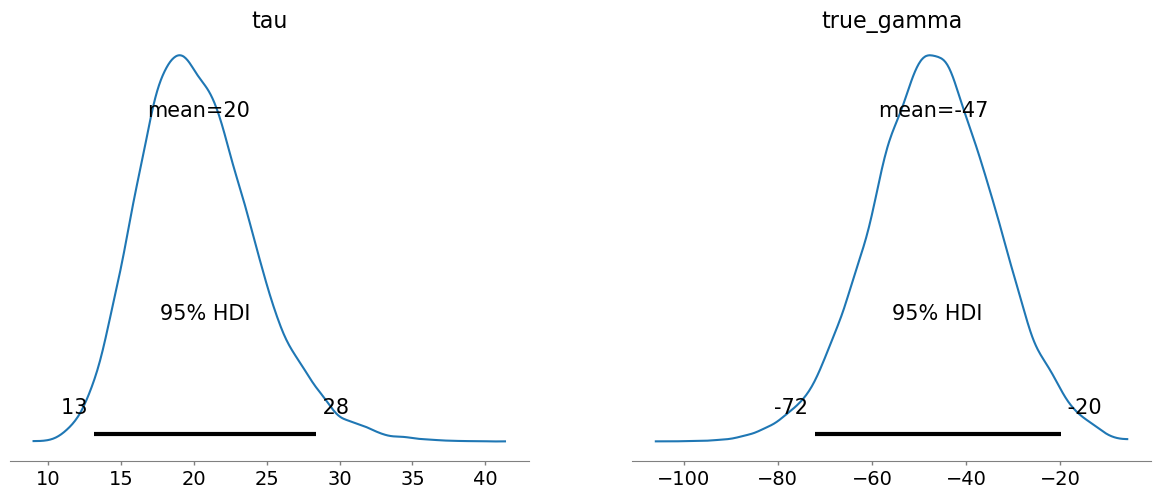

In [628]:
az.plot_posterior(kate_trace,var_names=["tau","true_gamma"],hdi_prob=.95)

# Emergent constraints
How do emergent constraints affect the estimate?
TO DO: explain how we incorporate uncertainty in emergent constraints, fold everything together, explain why we do this in batch rather than sequentially

In [289]:
import pdfplumber

In [427]:
with pdfplumber.open("Cox2013Supp1.pdf") as pdf:
    page = pdf.pages[0]
    coxtable = page.extract_table()

In [444]:
cox_df = pd.DataFrame(coxtable[1:], columns=coxtable[0])
cox_df

,,Model,\n\n{T}\n(K),\n\n{dCO /dt}\n2\n(ppmv/yr),Corr.\nCoeff.\nr,IAV Sensitivity\n(ppmv/yr/K)
0,A,HadCM3LC,0.17,1.85,0.88,9.7 +/- 0.7
1,B,IPSL,0.07,1.16,0.50,8.2 +/- 2.1
2,C,MPI,0.21,1.59,0.75,5.7 +/- 0.7
3,D,CCSM1,0.07,0.57,0.53,4.5 +/- 1.0
4,E,FRCGC,0.14,0.97,0.81,5.8 +/- 0.6
5,F,LOOP,0.15,1.61,0.28,2.9 +/- 1.4
6,G,HadCM3C-st,0.16,2.33,0.88,12.5 +/- 1.1
7,H,HadCM3C-a,0.15,1.14,0.72,5.6 +/- 0.8
8,I,HadCM3C-h,0.17,3.61,0.70,14.4 +/-2.3
9,,Obs (NCDC),0.09,0.75,0.65,5.1 +/-0.9


In [461]:
#Observed IAV and uncertainties
i_obs=np.where([x.find("Obs")>=0 for x in cox_df.Model.values])[0]
observed_quantities=cox_df["IAV Sensitivity\n(ppmv/yr/K)"][i_obs].values
observed_means=[float(x.split("+")[0]) for x in observed_quantities]
observed_stds=[float(x.split("-")[1]) for x in observed_quantities]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_92742/1617528526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["model"] = pd.Categorical(filtered_df["model"], categories=order, ordered=True)


Text(0, 0.5, 'γL (PgC K-1)')

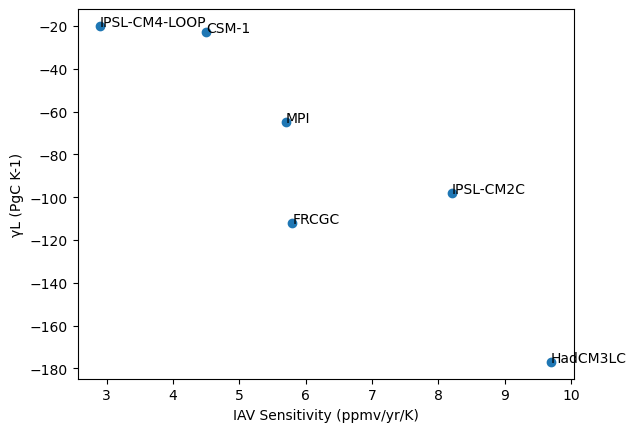

In [436]:
#get numbers for internal variability
iav=np.array([float(x.split("+")[0]) for x in cox_df[cox_df.columns[-1]].values])
# assumed overlap between models in cox et al 2013 and Jones and Friedlingstein
#CHRIS- please confirm that IPSL in Cox 2013 = IPSL-CM2C, CCSM1 = CSM-1, and LOOP = IPSL-CM4-LOOP
subset=["HadCM3LC","IPSL-CM2C","MPI","CSM-1","FRCGC","IPSL-CM4-LOOP"]
filtered_df=df[df["model"].isin(subset)]
order=subset
filtered_df["model"] = pd.Categorical(filtered_df["model"], categories=order, ordered=True)
sorted_df = filtered_df.sort_values("model")
gams=sorted_df["γL (PgC K-1)"].values.astype(np.float32)
plt.scatter(iav[:6],gams)
for i, txt in enumerate(subset):
    plt.annotate(txt, (iav[i], gams[i]))
plt.xlabel("IAV Sensitivity (ppmv/yr/K)")
plt.ylabel("γL (PgC K-1)")

In [504]:


# Example input: Replace with your actual data
# mu_i = np.array([0.2, 0.5, 0.3, 0.6])    # reported means from studies
# s_i = np.array([0.1, 0.15, 0.1, 0.2])    # reported standard deviations
mu_i = observed_means   # reported means from studies
s_i = observed_stds    # reported standard deviations
n_studies = len(mu_i)

with pm.Model() as meta_analysis_model:
    # Overall population mean
    mu = pm.Normal("mu", mu=np.average(observed_means), sigma=np.average(observed_stds))
    
    # Inter-study standard deviation (heterogeneity)
    tau = pm.HalfNormal("tau", sigma=np.std(observed_means))  # small, narrow prior
    
    # True effect for each study
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=n_studies)
    
    # Observed study estimates
    obs = pm.Normal("obs", mu=theta, sigma=s_i, observed=mu_i)
    
    # Sample from posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True,target_accept=.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'mu'}, ylabel='Density'>

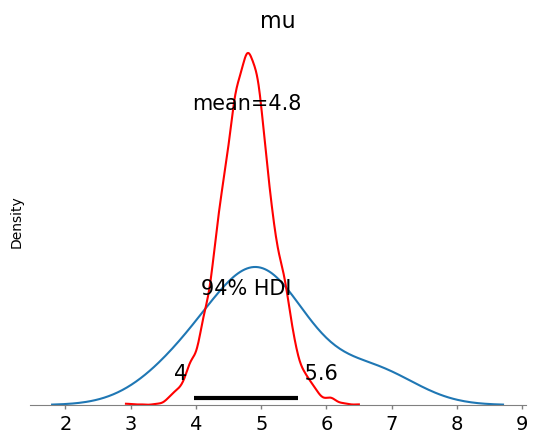

In [505]:
ax=plt.subplot(111)
sns.kdeplot(mu_i)
az.plot_posterior(trace.posterior.mu,color="r",ax=ax)

array([[<Axes: title={'center': 'mu'}>,
        <Axes: title={'center': 'theta\n0'}>,
        <Axes: title={'center': 'theta\n1'}>,
        <Axes: title={'center': 'theta\n2'}>],
       [<Axes: title={'center': 'theta\n3'}>,
        <Axes: title={'center': 'theta\n4'}>,
        <Axes: title={'center': 'theta\n5'}>,
        <Axes: title={'center': 'tau'}>]], dtype=object)

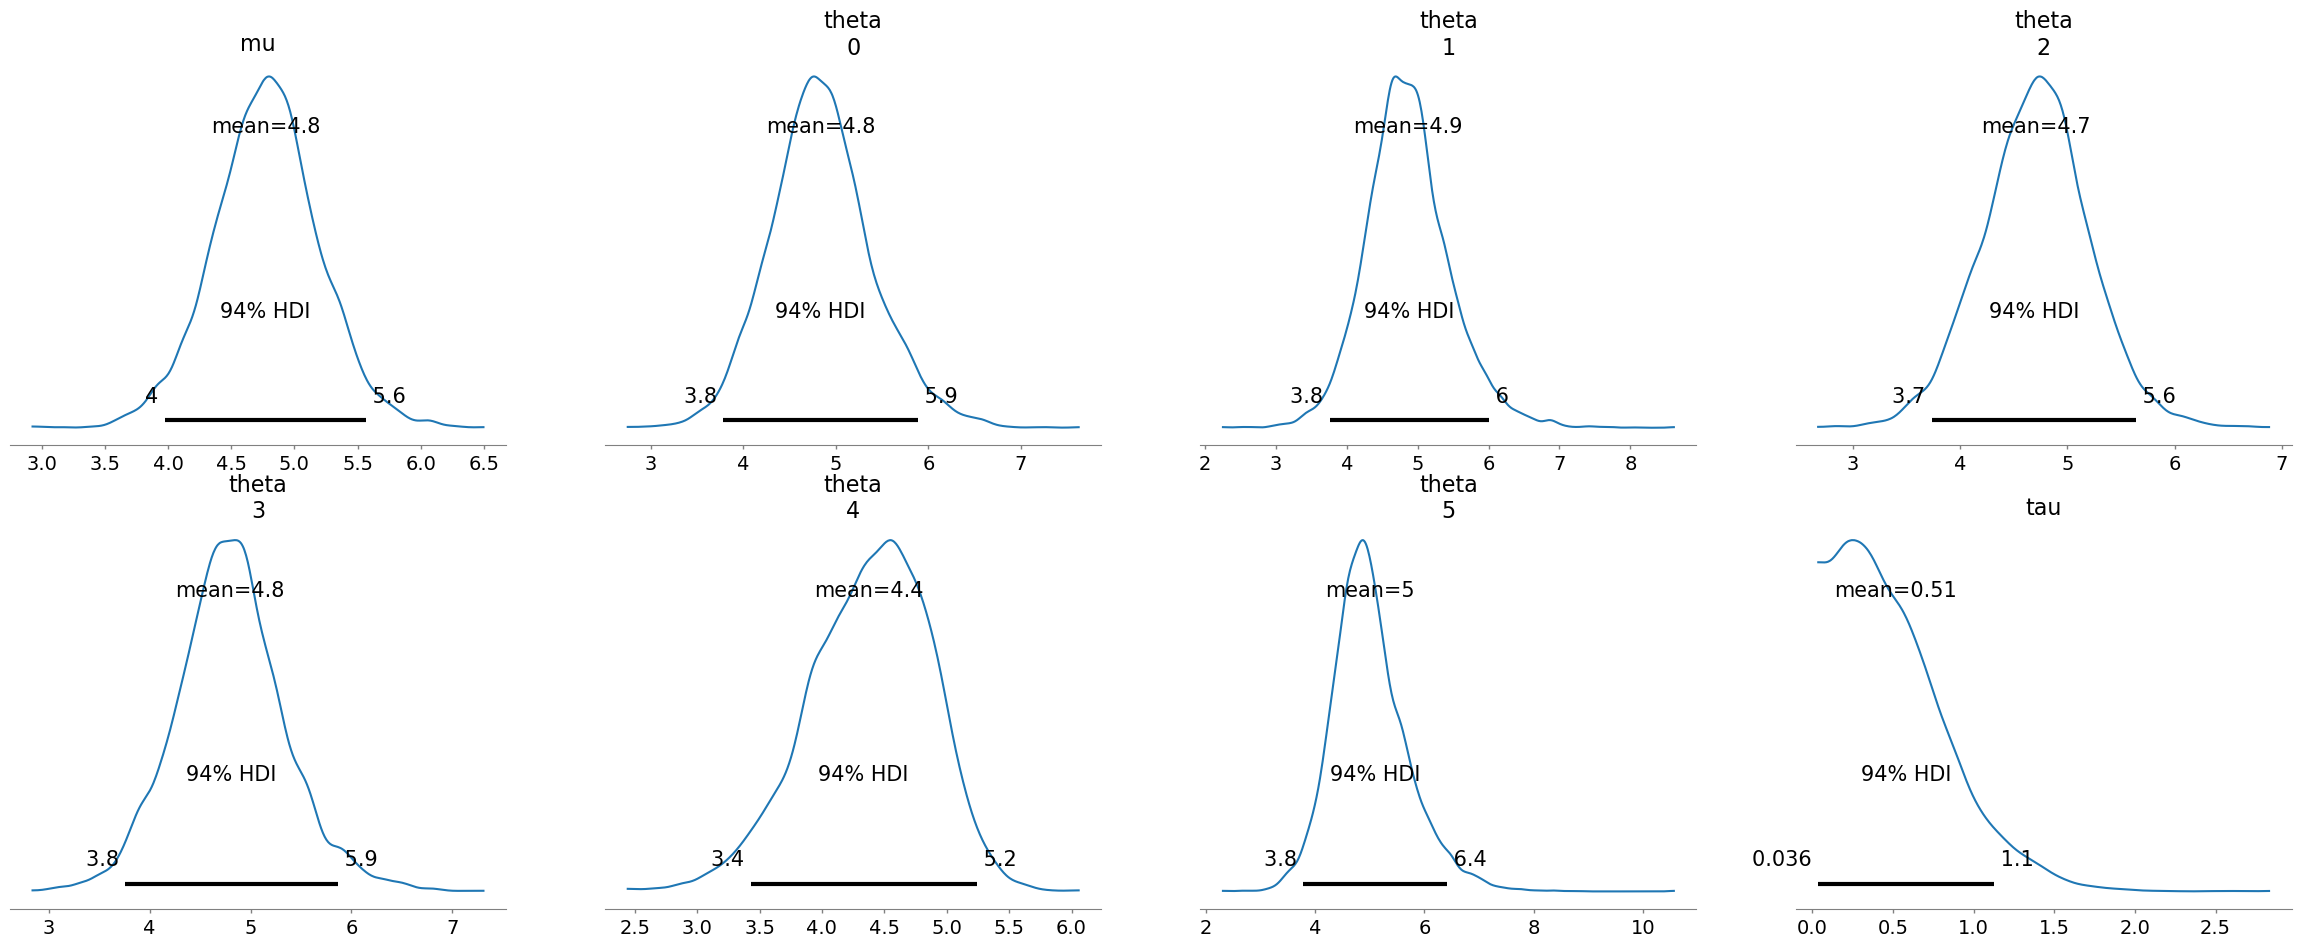

In [506]:
az.plot_posterior(trace.posterior)

In [437]:
# emergent constraint- find posteriors 
with pm.Model() as ec_model:
    ##########################################################
    # STEP 1: Assume γL is linearly related to IAV sensitivity.
    # Fit a simple model IAV = mγ+b+ϵ (where ϵ ~ N(0, σ)) 
    # Find posteriors for m,b,σ
    ##########################################################
    #priors on the hyperparameters m, b, sigma
    m=pm.Normal("m",0,10) 
    b=pm.Normal("b",0,10)
    sigma=pm.HalfNormal("sigma",10)
    # use the data (C4MIP IAV and gamma) to learn the hyperpriors
    D=pm.Normal("D",mu=m*gams+b,sigma=sigma,observed=iav[:6])

    # STEP 2: Get P(γ|true_IAV)
    γ = pm.Normal("γ",-100,100)
    # The true value of IAV, whatever it is, will constrain γ
    true_IAV = pm.Normal("true_IAV",mu=m*γ+b,sigma=sigma)
    
    # STEP 3: Estimate the true IAV from observations 
    #we expect there might be a little structural variance between the observations
    tau_obs=pm.HalfNormal("tau_obs",1)
    thetai=pm.Normal("thetai",mu=observed_means,sigma=observed_stds)
    
    
    
    
    #γ = pm.Normal("γ",np.average(gammas["C4MIP"]),np.std(gammas["C4MIP"]))
    γ = pm.Normal("γ",-100,100)
    true_IAV = pm.Normal("true_IAV",0,10)
    gissobs=pm.Normal("obs_IAV",mu=m*γ+b,sigma=sigma,observed=[4.9])
    ec_trace=pm.sample(1000,target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, sigma, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [438]:
with ec_model:
    ec_ppd=pm.sample_posterior_predictive(ec_trace)

Sampling: [D, obs_IAV]


<Axes: title={'center': 'obs_IAV\n0'}>

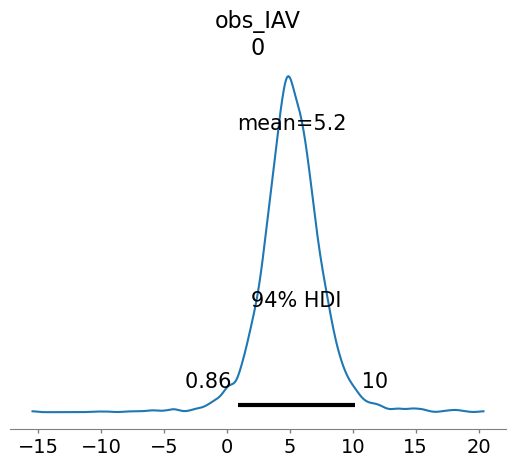

In [439]:
az.plot_posterior(ec_ppd.posterior_predictive.obs_IAV)

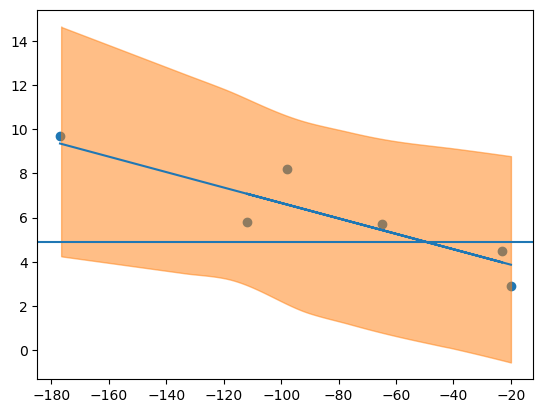

In [507]:
# Posterior predictive distribution
plt.scatter(gams,iav[:6])
plt.plot(gams,float(ec_trace.posterior.m.mean())*gams+float(ec_trace.posterior.b.mean()))
az.plot_hdi(gams,ec_ppd.posterior_predictive.D,hdi_prob=.95)
plt.axhline(4.9)

array([<Axes: title={'center': 'm'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'γ'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

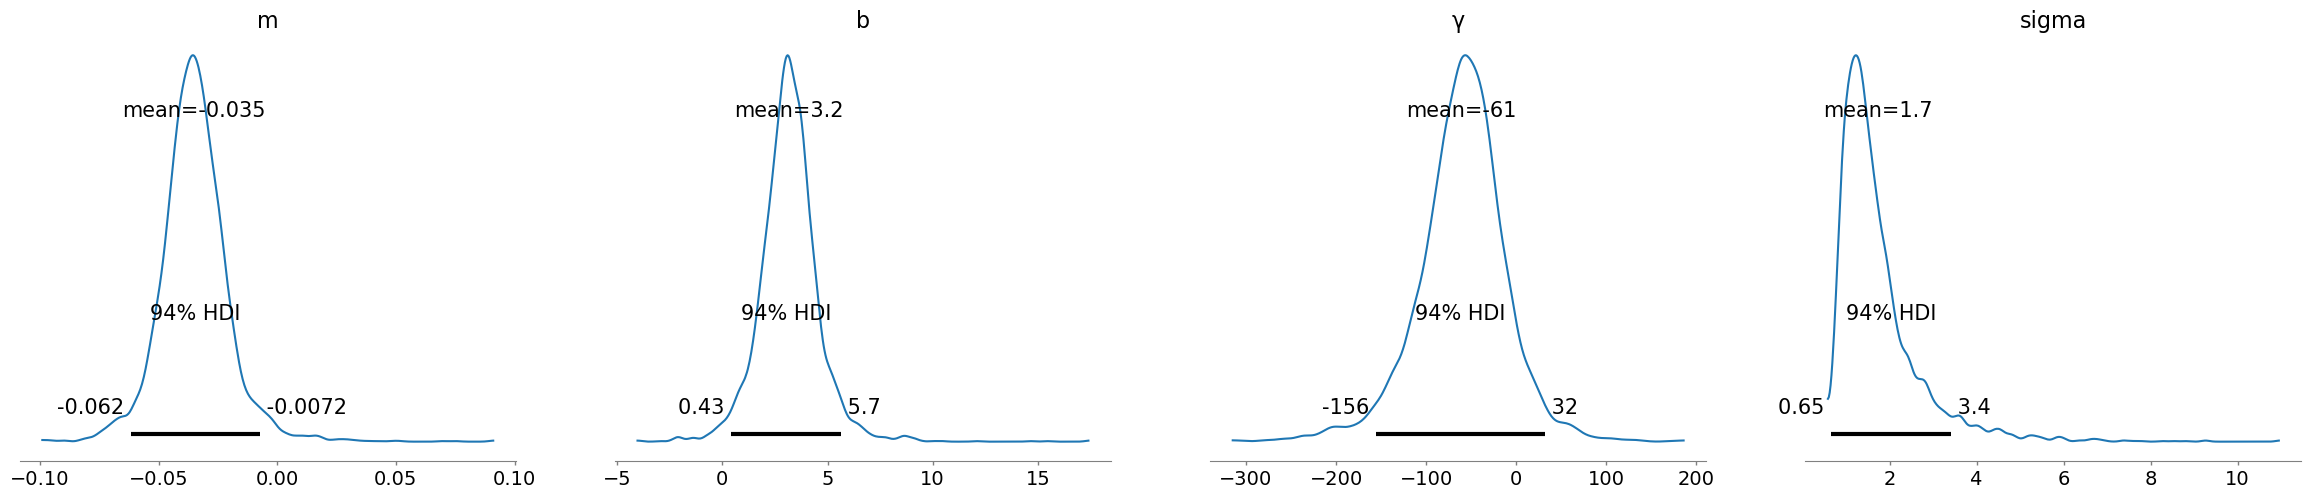

In [442]:
# Posterior distributions for the hyperparameters given the data P(\theta|D)
az.plot_posterior(ec_trace)

In [408]:
np.average(gammas["C4MIP"])

-78.63636

In [509]:
# this is P(IAV | gamma): the likelihood.  Now I need to get P(gamma|IAV) P(gamma).  P(gamma) comes from the models.  
#get the posterior for IAV obs given gamma
with pm.Model() as constrain_model:
    #prior on γ
    #γ = pm.Normal("γ",np.average(gammas["C4MIP"]),np.std(gammas["C4MIP"]))
    γ = pm.Normal("γ",np.average(gams),np.std(gams))
    # posteriors from above
    m = pm.Normal("m",float(ec_trace.posterior.m.mean()),float(ec_trace.posterior.m.std()))
    b = pm.Normal("b",float(ec_trace.posterior.b.mean()),float(ec_trace.posterior.b.std()))
    gissobs=pm.Normal("obs_IAV",mu=m*γ+b,sigma=1.8,observed=[4.9])
    test_trace=pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, m, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'γ'}, ylabel='Density'>

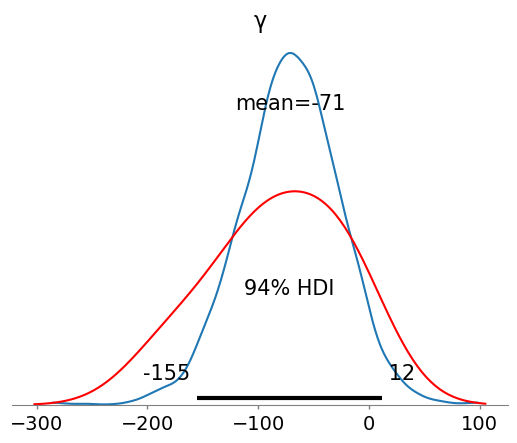

In [510]:
az.plot_posterior(test_trace.posterior.γ)
sns.kdeplot(gams,c="r")

In [143]:
#assume all the samples are iid- get the sample mean+= standard error
with pm.Model() as trivial_model:
    truevalue=pm.Normal("truevalue",0,1)
    sigma=pm.HalfNormal("sigma",1)
    lik=pm.Normal("pooled_beta",mu=truevalue,sigma=sigma,observed=pooled)
    trivial_trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [truevalue, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [164]:

# Your observed data
x = pooled # Replace with your actual data
n = len(x)

with pm.Model() as random1_model:
    # Hyperparameters
    mu = pm.Normal("mu", mu=0, sigma=1000)  # Non-informative prior
    tau = pm.HalfCauchy("tau", beta=5)      # Prior on heterogeneity

    # Latent true means for each model
    theta = pm.Normal("truevalue", mu=mu, sigma=tau, shape=n)

    # Observational noise (assumed same for all if unknown)
    #sigma = pm.HalfNormal("sigma", sigma=1)
    sigma=1

    # Likelihood
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=x)

    # Inference
    random1_trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, truevalue]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'sigma'}>

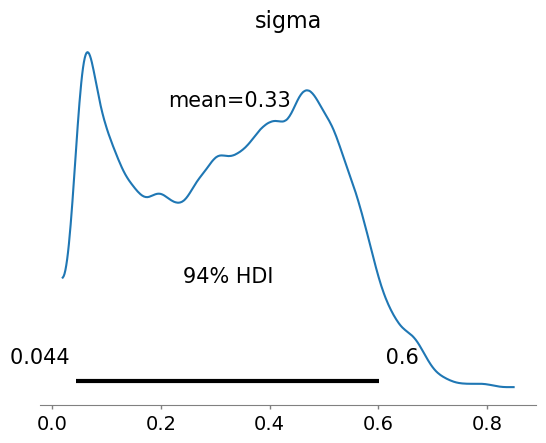

In [165]:
az.plot_posterior(random_trace.posterior.sigma)

<Axes: title={'center': 'truevalue\n0'}, ylabel='Density'>

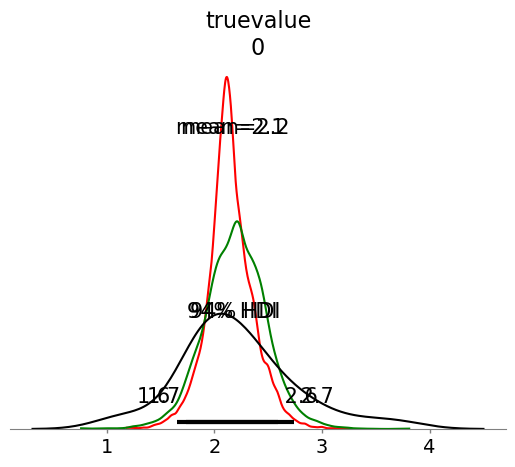

In [167]:
ax=plt.subplot()
# az.plot_posterior(trivial_trace.posterior.truevalue,ax=ax)
az.plot_posterior(random_trace.posterior.truevalue,ax=ax,color="r")
az.plot_posterior(random1_trace.posterior.truevalue,ax=ax,color="g")
sns.kdeplot(pooled,color="k")

In [ ]:
# or do it in three groups



In [139]:
# np.random.seed(42)
# n_groups=3
# keys=["C4MIP","CMIP5","CMIP6"]
# gammas={}
# gammas["C4MIP"]=c4mip["γtot (PgC K-1)"]
# gammas["CMIP5"]=cmip5["γtot (PgC K-1)"]
# gammas["CMIP6"]=cmip6["γtot (PgC K-1)"]
# y=np.concatenate([gammas[k].values for k in keys])
# group_ids=np.concatenate([np.repeat(k,len(gammas[k].values)) for k in keys])
# df = pd.DataFrame({
#     "group": group_ids,
#     "y": y
# })
# data[


# Simulate data
np.random.seed(42)
n_groups = 10
n_per_group = 20
group_ids = np.repeat(np.arange(n_groups), n_per_group)
true_group_means = np.random.normal(0, 1.0, size=n_groups)
y = true_group_means[group_ids] + np.random.normal(0, 1.0, size=n_groups * n_per_group)

# Create a DataFrame
df = pd.DataFrame({
    "group": group_ids,
    "y": y
})

# Model
with pm.Model() as model:
    # Convert group index to a shared variable
    group_idx = pm.Data("group_idx", df["group"].values)
    
    # Hyperpriors for group intercepts
    mu_a = pm.Normal("mu_a", mu=0, sigma=1)
    sigma_a = pm.HalfNormal("sigma_a", sigma=1)

    # Random intercepts
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_groups)
    print(a[group_idx].shape.eval())
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=a[group_idx], sigma=1.0, observed=df["y"])

    # Sampling
   # trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Summary
#az.summary(trace, var_names=["mu_a", "sigma_a", "a"])


[200]


/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [ ]:
n_groups = 10
n_per_group = 20
group_ids = np.repeat(np.arange(n_groups), n_per_group)
true_group_means = np.random.normal(0, 1.0, size=n_groups)
y = true_group_means[group_ids] + np.random.normal(0, 1.0, size=n_groups * n_per_group)
y.shape

print(len(np.append(np.repeat("C4MIP",len(c4mip)),np.repeat("CMIP5",len(cmip5)))))
np.concatenate([c4mip,cmip5,cmip6],axis=None).shape
c4mip

In [99]:
group_ids=["C4MIP","CMIP5","CMIP6"]
n_groups=3
group_ids=np.append(
    np.append(np.repeat("C4MIP",len(c4mip)),np.repeat("CMIP5",len(cmip5))),
    np.repeat("CMIP5",len(cmip6)))
y=np.stack([c4mip,cmip5,cmip6])
# data = pd.DataFrame({
#     "group": group_ids,
#     "y": y
# })
y

ValueError: all input arrays must have the same shape

In [89]:
az.hdi(trivial_trace.posterior.truebeta, hdi_prob=.95)


<xarray.Dataset> Size: 64B
Dimensions:   (hdi: 2)
Coordinates:
  * hdi       (hdi) <U6 48B 'lower' 'higher'
Data variables:
    truebeta  (hdi) float64 16B 1.982 2.386

In [93]:
se=np.std(pooled)/np.sqrt(len(pooled))
np.average(pooled)+2*se

2.3912869266113295